### HELLO! This is a simple tool I have created to query optical photometry for nearby galaxies at a location of you choosing from SDSS DR12 in Vizier. Hope you find it useful! --Vic 07/31/2020

In [7]:
from urllib.parse import urlencode
from urllib.request import urlretrieve

from astroquery.vizier import Vizier
from astroquery.mast import Observations, Catalogs
from astropy.io.votable import parse as votable_parse
from astropy import utils, units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.table import Table
from astropy.io import ascii, fits

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

import shutil, IPython.display, os, copy, pickle, statistics, numpy as np
import extinction, dustmaps.sfd, sys, math
import casjobs

dustmaps.sfd.fetch()
sfd = dustmaps.sfd.SFDQuery()

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.
Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


In [8]:
# Get ramin, ramax, demin, demax corners of a box centered at coord with size
def get_ra_dec_box(coord, size):
    ra = coord.ra.degree
    dec = coord.dec.degree
    
    RAboxsize = DECboxsize = float(0.1)

    # get the maximum 1.0/cos(DEC) term: used for RA cut
    demin = dec-0.5*DECboxsize
    if demin<=-90.0:demin=-89.9
    demax = dec+0.5*DECboxsize
    if demax>=90.0:demax=89.9

    invcosdec = max(1.0/math.cos(dec*math.pi/180.0),
                        1.0/math.cos(demin  *math.pi/180.0),
                        1.0/math.cos(demax  *math.pi/180.0))

    # get the (conservative) boxlimits
    ramin = ra-0.5*RAboxsize*invcosdec
    ramax = ra+0.5*RAboxsize*invcosdec
    demin = dec-0.5*DECboxsize
    demax = dec+0.5*DECboxsize
    
    return(ramin, ramax, demin, demax)

def download_url_to_file(url, filename, tempdir='delme/'):
    
    if not os.path.exists(tempdir):
        os.makedirs(tempdir)
    
    if os.path.exists(tempdir+filename):
        return(0)
    dat = utils.data.download_file(url, cache=False, show_progress=True, timeout=120)
    shutil.move(dat, tempdir+filename)
    return(0)

def downloadPS1(coord,  filt, tempdir='delme/'):

    # Check for filter
    if not filt: filt=='r'
            
    obsTable = Observations.query_region(coord, radius=5*u.arcmin)
    
    masks = []
    masks.append([str(t).upper() == 'PS1' for t in obsTable['obs_collection']])
    masks.append([str(p).upper() == 'IMAGE' for p in obsTable['dataproduct_type']])
    masks.append([str(r).upper() == 'PUBLIC' for r in obsTable['dataRights']])
    masks.append([str(f).lower() == filt for f in obsTable['filters']])
    
    masks = list(map(list, zip(*masks)))
    mask = np.array([all(l) for l in masks])
    
    obsTable = obsTable[mask]
    
    if len(obsTable)==0:
        error = 'ERROR: no matching PS1 images for ra={ra}, dec={dec}.'
        print(error.format(ra=ra, dec=dec))
        return(1)
    else:
        prodList = Observations.get_product_list(obsTable)
        prodList = prodList[prodList['productType']=='SCIENCE']
        prodList = prodList[prodList['description']=='stack data image']
        
        message = 'We need to download {n} PS1 images.'
        print(message.format(n=len(prodList)))
        
        for product in prodList:
            filename = product['productFilename']
            outfile = filename.replace('.fz','')
            outname = outfile.replace('.fits', '_mod.fits')
            url = 'https://mast.stsci.edu/api/v0/download/file?uri='+product['dataURI']
            if os.path.isfile(tempdir+outname):
                message = '{filename} exists.  Continuing...'
                print(message.format(filename=tempdir+outname))
            else:
                outfile = tempdir+filename+'.fz'
                errflag = download_url_to_file(url, filename+'.fz', tempdir=tempdir)
                
                hdu  = fits.open(outfile)

                # Need to reweight the data for PS1 by effective zpt
                exptime = hdu[1].header['EXPTIME']
                boffset = hdu[1].header['BOFFSET']
                bsoften = hdu[1].header['BSOFTEN']
                a = 1.0857362

                # Get the image data from the file
                img  = hdu[1].data
                mask = np.isnan(hdu[1].data)

                # Adjust data values for asinh compression
                data  = boffset + bsoften * (np.exp(img/a) - np.exp(-img/a))
                zpt   = 25.0 + 2.5 * np.log10(exptime)
                data  = data * 10**(0.4*(27.5-zpt))
                hdu[1].data = data

                # Reset the mask values
                hdu[1].data[mask] = np.nan

                # Write out modified file
                outname = outfile.replace('.fits', '_mod.fits').replace('.fz','')
                hdu.writeto(outname, overwrite=True)
                print('Wrote out: {0}'.format(outname))

def docasjobsstrm(coord, size=0.1, meta=['raMean','decMean','z_phot','z_photErr'],
                 mask=True):
    
        ra = coord.ra.degree ; dec = coord.dec.degree
        ramin, ramax, demin, demax = get_ra_dec_box(coord, size)

        query = 'select '
        meta_query = ', '.join(['c.' + val for val in meta])
        query += meta_query
        query += ' from catalogRecordRowStore c '
        query += ' where '
        query += ' c.raMean between {ramin} and {ramax}'.format(ramin=ramin,
            ramax=ramax)
        query += ' and c.decMean between {demin} and {demax}'.format(demin=demin,
            demax=demax)

        print('running query:')
        print(query)

        jobs = casjobs.CasJobs(userid='892987546', password='BossTent1',
            base_url='http://mastweb.stsci.edu/ps1casjobs/services/jobs.asmx')

        job_output = jobs.quick(query, context='HLSP_PS1_STRM',
            task_name='PS1cat_ra%.7f_dec%.7f'%(ra,dec))

        names = meta

        table = ascii.read(job_output, names=names)
        
        if mask and 'z_phot' in table.keys():
            # Mask values with missing photo-z and anomalously negative values
            table = table[table['z_phot']!=-999.0]
            table = table[table['z_phot']>-0.01]
            
        return(table)

# Input coordinates and calculate Milky Way extinction

In [9]:
#We want to define a coordinate and a radius that we can use to search in the catalog
ra  = '01:43:07.68'
dec = '-17:29:33.1'

# Parse coordinate and get MW Av
coord = SkyCoord(ra, dec, unit=(u.hour, u.deg), frame="icrs")
av = sfd(coord) * 3.1
print('Milky Way Av={0} mag'.format(('%7.4f'%av).strip()))

Milky Way Av=0.0587 mag


#### PS1 image download, photo-z, and catalog search methods

In [11]:
# Download image at coordinates in given band
#downloadPS1(coord, 'r')

# Download photo-z catalog in a box with given size
strm = docasjobsstrm(coord, size=5.0/3600)
print(strm)

# Download photometry from PS1 DR2
catalog = Catalogs.query_region(coord, radius=0.1, catalog='Panstarrs', 
    data_release='dr2', table='mean')
print(catalog)

running query:
select c.raMean, c.decMean, c.z_phot, c.z_photErr from catalogRecordRowStore c  where  c.raMean between 25.72956125703653 and 25.83443874296347 and c.decMean between -17.542527777777778 and -17.442527777777777
   raMean     decMean          z_phot          z_photErr     
----------- ------------ ----------------- ------------------
25.72987937 -17.54212794 0.913077265024185  0.748812441419843
25.78335082 -17.54205928 0.976583659648895  0.509411159812723
25.79507515 -17.54235222 0.589529395103455  0.139408498978924
  25.733677 -17.53568942  0.66118535399437   0.25178944859945
25.75118238 -17.53770342 0.855346322059631  0.113080592110023
25.75480229  -17.5390767 0.945284515619278  0.193095382125339
25.75886121 -17.53969174 0.925296038389206   0.49462536870571
25.76003951 -17.53557315 0.272550001740456  0.113864665321981
25.76621829 -17.54146256 0.730815082788467    0.1223036188625
25.77113094 -17.54099038 0.717653870582581  0.208061672351393
        ...          ...       

In [ ]:
# Search in SDSS DR 12 catalog from Vizier. Make sure the row limit is large so you include all the observations! 
v = Vizier(columns=['_r', 'RA_ICRS', 'DE_ICRS', 'ObsDate', 'class','umag','gmag', 'rmag', 'imag', 'zmag', 'zph' ], 
           catalog=['V/147'], row_limit = 1000000000)

# Adjust the search radius here!  
result = v.query_region(co, radius=2.564*u.arcmin)

result_table = Table(result)

# We write the result as a table and it will be saved in a text file! 
ascii.write(result_table, 'GRB200522A_res.txt', overwrite=True)

### We will sort thorugh the text file that was just being saved in order to get the photometry we want! 

In [3]:
# Function for the handlinng the downloaded data text function
def readData(String):
    file = os.path.abspath(String)
# Open the text file
    infile = open(file, 'r')
    data = infile.read().split(',' and '\n')
    infile.close()
    lst =data[1:-1]
    
    return lst


In [4]:
# Function to sort through our table now that we have it in a list
def sorting(lst):
    s = ''
    no_punct = ""
    string = s.join(lst)
    punctuation = '()"'
    sorted_list =[]
# Split the big list into a nested list 
    for i in range(len(lst)):
        sorted_list.append(lst[i].split(','))

# Combine everything in the nested list into a list of strings
    string_list = []
    for i in sorted_list:
        for j in i:
            string = s.join(j)
            string_list.append(string)

# Take away the punctuations in the list so we don't have to worrry
#   about them later on in the data
    big_list = []
    for words in string_list:
        for char in words:
            if char in punctuation:
                words = words.replace(char, '')
        big_list.append(words)
        
# Big list is the list that contains all the values without the punctuations


# You can decide how many variables you want to obtain from the catalogs,
# although the current variables should be comprehensive for Prospector use
# or any sorts of plotting.

    num_of_variable = 11

# Split those numbers into nested lists and store them in thet 'nest' list
#   and then we will beready to analyze the actual data! 
    count = 1
    small_list = []
    nest = []
    for i in big_list: 
        small_list.append(i)
        if count % num_of_variable == 0:
            #small_list.append(distance[(count/num_of_variable)-1])
            nest.append(small_list)
            small_list = []
        count += 1
    return(nest)


In [5]:
def data(nest):
# Find all galaxy-only photometry and store that in a list
    num_of_variable = 11
    galaxy_list = []
    for i in range(len(nest)):
        for j in range(len(nest[i])):
            if nest[i][j] == ' 3':
                galaxy_list.append(nest[i])
    
# We want to do a quick analysis on the photometric redshift so we will
# make a list of just redshifts here
    phot_z_list = []         
    for i in range(len(galaxy_list)):
        phot_z_list.append(galaxy_list[i][(num_of_variable - 1)])


# Getting rid of all the observations that have no z_phot (nan and -9999.0) 
    c_list = []
    galaxy_list_org = copy.deepcopy(galaxy_list)
 
    for i in range(len(galaxy_list_org)):
        if phot_z_list[i] != ' nan':
            c_list.append(galaxy_list[i])
            
    c_list_org = copy.deepcopy(c_list)
    for i in c_list_org:
        if i[(num_of_variable-1)] == ' -9999.0':
            c_list.remove(i)
    
# EVERTHING WE NEED IS NOW IN THIS INFO_LIST IN NUMBERS
    info_list = []
    for i in range(len(c_list)):
        for j in range(len(c_list[i])):
            c_list[i][j].strip()
            info_list.append(float(c_list[i][j].strip()))

    count = 1
    small = []
    final = []
    for i in info_list: 
        small.append(i)
        if count % num_of_variable == 0:
            final.append(small)
            small = []
        count += 1
    return final


In [6]:
def ordering(final):
    #Make a r_mag list
    r_mag = []
    for i in range(len(final)):
        for j in range(len(final[i])):
            if j == 7:
                r_mag.append(final[i][7])
    
    #Make a distance list
    dist = []
    for i in range(len(final)):
        for j in range(len(final[i])):
            if j == 0:
                dist.append(final[i][0])
                
    # Here, we want to sort through our photometry
    # You can sort the photometry either based on r_mag or distance. Just simply
    # Change dist to r_mag or r_mag to dist and taa daa! 

    # BubbleSort 
    n = len(dist) 
  
    # Traverse through all array elements 
    for i in range(n-1): 
    # range(n) also work but outer loop will repeat one time more than needed. 
  
        # Last i elements are already in place 
        for j in range(0, n-i-1): 
            # traverse the array from 0 to n-i-1 
            # Swap if the element found is greater 
            # than the next element 
            if dist[j] > dist[j+1]: 
                dist[j], dist[j+1] = dist[j+1], dist[j]
                final[j], final[j+1] = final[j+1], final[j]
    for i in final:
        print(i)
        
    #print(len(final))


    # Write the ordered photometry as a text file using pickle so they can be in floats and not integers 
    with open('GRB200522A.txt', 'wb') as fp:
        pickle.dump(final,fp)

    # Use this to open the pickled text file
    with open('GRB200522A.txt', 'rb') as fp:
        b = pickle.load(fp)
    #print(b)
    
    # You can also write your result using this method since pickle does not allow you to read it in a text editor 
    #np.savetxt('200522A_result_np.txt', np.c_[final])
    
    # Then you can use this to unpack the text file :)
    #final = np.loadtxt('200522A_result_np.txt',unpack=True)
    

In [7]:
# We will get our final result by calling the main function
def main():
    the_lst = readData('GRB200522A_res.txt')
    nest_list = sorting(the_lst)
    final_data = data(nest_list)
    phot = ordering(final_data)
    
main()

# Here are some tips for if you don't use the same number of columns or the same format to extract data from Vizier:
    # Number of variables would need to change depending on how many columns there are
    # Numbers need to change if z_phot is not the last element in the columns

[0.0324, 5.682155, -0.282646, 2003.8855, 3.0, 22.55500030517578, 22.104999542236328, 21.17300033569336, 20.874000549316406, 20.69499969482422, 0.4269]
[0.1957, 5.680197, -0.28045, 2003.8855, 3.0, 23.479000091552734, 22.55500030517578, 21.448999404907227, 21.13800048828125, 20.96299934387207, 0.4004]
[0.6549, 5.685248, -0.272743, 2003.8855, 3.0, 23.576000213623047, 23.569000244140625, 22.645000457763672, 21.777000427246094, 21.922000885009766, 0.6173]
[0.6944, 5.68058, -0.27168, 2003.8855, 3.0, 25.285999298095703, 24.514999389648438, 22.882999420166016, 22.625999450683594, 21.81100082397461, 0.4422]
[0.7043, 5.691228, -0.290429, 2003.8855, 3.0, 20.26099967956543, 19.084999084472656, 18.506000518798828, 18.11199951171875, 17.91699981689453, 0.1163]
[0.7415, 5.674729, -0.273177, 2003.8855, 3.0, 21.96299934387207, 20.770999908447266, 20.392000198364258, 20.30299949645996, 20.00200080871582, 0.1293]
[0.7545, 5.679355, -0.270872, 2003.8855, 3.0, 23.63599967956543, 22.929000854492188, 22.0779

### If you want an image of where you are looking at, you can use this!

In [8]:
#If you have J2000 coordinates, you can convert them to degrees here! 
coord = SkyCoord('00h22m43.68s', '-00d16m59.4s', frame='icrs')
coord

<SkyCoord (ICRS): (ra, dec) in deg
    (5.682, -0.28316667)>

In [9]:
impix = 1024
imsize = 12*u.arcmin
cutoutbaseurl = 'http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'
query_string = urlencode(dict(ra=5.682, 
                                     dec=-0.28316667, 
                                     width=impix, height=impix, 
                                     scale=imsize.to(u.arcsec).value/impix))
url = cutoutbaseurl + '?' + query_string

# this downloads the image to your disk
urlretrieve(url, '200522A_SDSS_cutout.jpg')

('200522A_SDSS_cutout.jpg', <http.client.HTTPMessage at 0x2676d7230c8>)

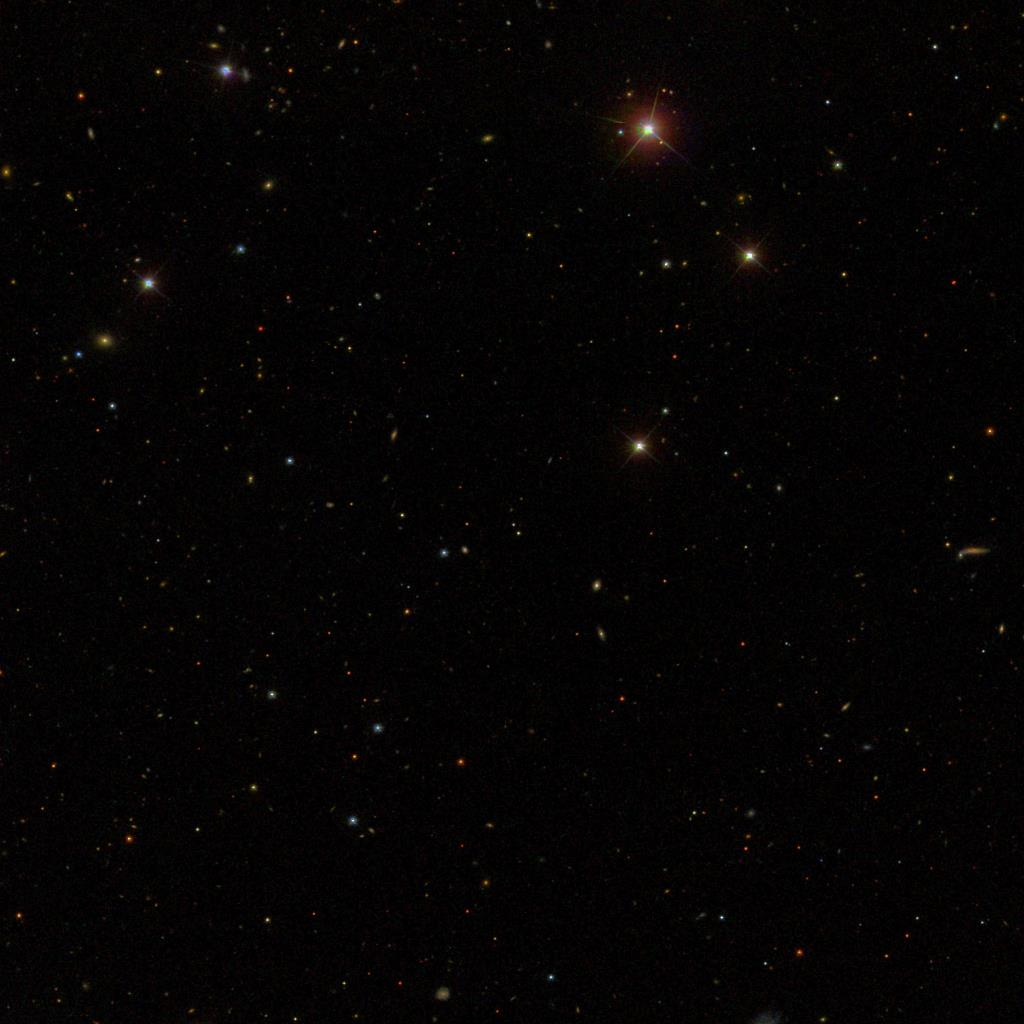

In [10]:
#Here is an image of the cut out. I bet it looks super pretty! 
IPython.display.Image('200522A_SDSS_cutout.jpg')

### Once you have the results, there are several things you can do. One of them is finding the probability chance coincident (Pcc) of the nearby galaxies which essentially tells you how likely that the GRB originated from a galaxy. The lower the Pcc, the more probable. 

In [14]:
# The function you can use to calcilate that is here:
def pcc(r,m): 
    sigma = (1/(0.33*np.log(10)))*10**(0.33*(m-24)-2.44) 
    prob = 1-np.exp(-(np.pi*(r**2)*sigma)) 
    return prob

# An example of what a plot of Pcc as a function of distance looks like is here. This is what I did for GRB200522A. 
import numpy as np
with open('GRB200522A.txt', 'rb') as fp:
    result = pickle.load(fp)

# Make a list of r_mag that corresponds to each galaxy near GRB200522A
r_mag = []
for i in range(len(result)):
    for j in range(len(result[i])):
        if j == 7:
            r_mag.append(result[i][7])
#print(r_mag)

# Distance is in arcsecond, not arcminute of the galaxy from GRB200522A
distance = []
for i in range(len(result)):
    for j in range(len(result[i])):
        if j == 0:
            distance.append(result[i][0]*60)
#print(distance)

# Make a list of photometric redshift
phot = []
for i in range(len(result)):
    for j in range(len(result[i])):
        if j == 10:
            phot.append(result[i][10])
#print(phot)
    
prob = []
for i in range(len(r_mag)):
    prob.append(pcc(distance[i],r_mag[i]))
        
#print(prob)

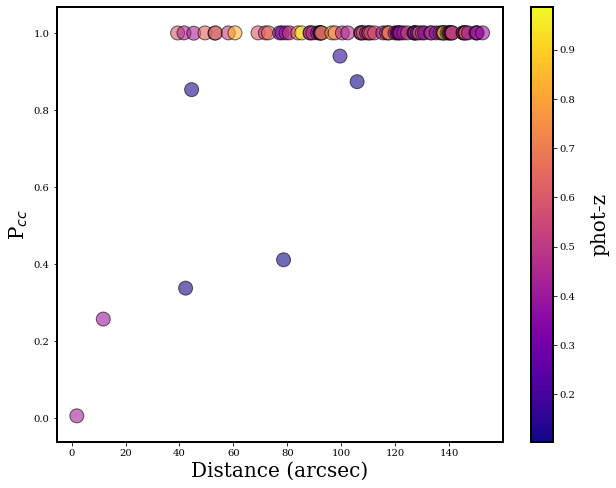

In [15]:
plt.rcParams['figure.figsize'] = [10, 8]
# = plt.subplot(21.137, 0.316, c=0.5537)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.linewidth'] = 2
plt.scatter(distance, prob, marker = "o", c=phot, cmap='plasma', alpha = 0.6, s=195, edgecolors='black')
plt.ylabel('P$_{cc}$', fontsize = 20)
plt.xlabel('Distance (arcsec)', fontsize = 20)
clb = plt.colorbar()
clb.solids.set_alpha(1)
clb.set_label('phot-z', fontsize = 20, labelpad=15, rotation=90)
plt.savefig('GRB200522a_pcc.png', format = 'pdf', dpi=300, bbox_inches="tight")
plt.show()

#### You can also sort out other lists of information such as the redshift and distance to make a scatter plot of redshifts as a function of distance. That can be helpful for figuring out whether the host is in a galaxy cluster or not. 